In [1]:
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length

In [2]:
COLORS = {-1: 'red', 1: 'blue'}

In [3]:
def generate_inliers(n, rng):
    return rng.uniform([0, 0], [0.5, 0.5], (n, 2))


def generate_outliers(n, rng, loc=[1, 1]):
    return rng.normal(loc, 0.1, (n, 2))

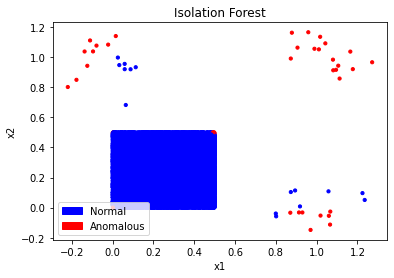

In [4]:
n_inliers = 1 << 16
n_outliers = 1 << 4
rng = np.random.default_rng(0)

x = np.concatenate([generate_inliers(n_inliers, rng),
                    generate_outliers(n_outliers, rng, [1, 1]),
                    generate_outliers(n_outliers, rng, [0, 1]),
                    generate_outliers(n_outliers, rng, [1, 0])])
ifo = IsolationForest(n_estimators=100, random_state=0, contamination=3 * n_outliers / x.shape[0])
ifo.fit(x)

plt.title('Isolation Forest')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(*x.T, c=[COLORS[l] for l in ifo.predict(x)], s=10)
blue_patch = mpatches.Patch(color='blue', label='Normal')
red_patch = mpatches.Patch(color='red', label='Anomalous')
plt.legend(handles=[blue_patch, red_patch], loc='lower left')

In [5]:
class FilteredIsolationForestMixin:
    def filter_trees(self, n_filter, X, X_labels):
        """
        Filter the trees out.
        
        Parameters
        ----------
        n_filter
            Number of trees to filter out.
            
        X
            The labeled objects themselves.
            
        X_labels
            The labels of the objects. 1 is anomaly, -1 is not anomaly, 0 is uninformative.
        """
        n_samples = X.shape[0]
        n_trees = len(self.estimators_)
        
        heights = np.empty(shape=(n_samples, n_trees))
        for tree_index in range(len(self.estimators_)):
            estimator = self.estimators_[tree_index]
            leaves_index = estimator.apply(X)
            n_samples_leaf = estimator.tree_.n_node_samples[leaves_index]
            
            heights[:, tree_index] = \
                np.ravel(estimator.decision_path(X).sum(axis=1)) + \
                _average_path_length(n_samples_leaf) - 1
            
        scores = (heights * X_labels.reshape(-1, 1)).sum(axis=0)
        indices = scores.argsort()[:-n_filter]
        
        self.estimators_ = [self.estimators_[i] for i in indices]
        self.estimators_features_ = [self.estimators_features_[i] for i in indices]
        # Can't set attribute:
        # self.estimators_samples_ = [self.estimators_samples_[i] for i in indices]


class FilteredIsolationForest(IsolationForest, FilteredIsolationForestMixin):
    pass


fifo = FilteredIsolationForest(n_estimators=200, random_state=0, contamination=3 * n_outliers / x.shape[0])
fifo.fit(x)

# Let's filter 100 trees out of 200
fifo.filter_trees(100, x[[-1, -1 - n_outliers, -1 - 2 * n_outliers], :], np.array([1, 1, 1]))

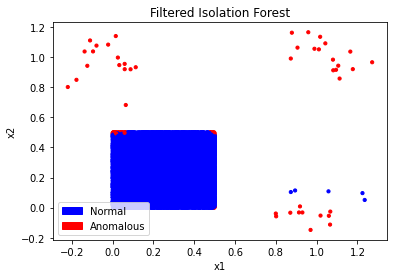

In [6]:
plt.title('Filtered Isolation Forest')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(*x.T, c=[COLORS[l] for l in fifo.predict(x)], s=10)
blue_patch = mpatches.Patch(color='blue', label='Normal')
red_patch = mpatches.Patch(color='red', label='Anomalous')
plt.legend(handles=[blue_patch, red_patch], loc='lower left')